In [1]:
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial.distance import squareform, pdist, cdist
from itertools import islice, combinations, product
from pyclustering.cluster.kmedoids import kmedoids
from collections import defaultdict
from sklearn.cluster import KMeans
from scipy.stats import hypergeom
from goatools import obo_parser
from scipy.linalg import eigh
from zipfile import ZipFile

import os
import time
import gzip
import graco
import shutil
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import Bio.UniProt.GOA as GOA
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sns.set()
pd.set_option("display.max_columns", 50)

DATA_DIRECTORY = "/home/clusterduck123/Desktop/git/supplements/data"
CPP_DIRECTORY = "/home/clusterduck123/Desktop/git/graco/graco/cpp"

In [3]:
RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw_data"
PPI_DIRECTORY = f"{DATA_DIRECTORY}/PPI"
ANNOTATIONS_DIRECTORY = f"{DATA_DIRECTORY}/annotations"
MATRIX_DIRECTORY = f"{DATA_DIRECTORY}/matrix"
CLUSTERS_DIRECTORY = f"{DATA_DIRECTORY}/clusters"

if not os.path.exists(DATA_DIRECTORY):
    os.makedirs(DATA_DIRECTORY)
        
if not os.path.exists(RAW_DATA_DIRECTORY):
    os.makedirs(RAW_DATA_DIRECTORY)     
    
if not os.path.exists(PPI_DIRECTORY):
    os.makedirs(PPI_DIRECTORY)
    
if not os.path.exists(ANNOTATIONS_DIRECTORY):
    os.makedirs(ANNOTATIONS_DIRECTORY)
    
if not os.path.exists(MATRIX_DIRECTORY):
    os.makedirs(MATRIX_DIRECTORY)
    
if not os.path.exists(CLUSTERS_DIRECTORY):
    os.makedirs(CLUSTERS_DIRECTORY)

# Downloads

### BioGRID

In [4]:
if not os.path.exists(RAW_DATA_DIRECTORY):
     os.makedirs(directory)

BioGRID_FILENAME = "BIOGRID-ORGANISM-3.5.177.tab2.zip"
BioGRID_URL = "https://downloads.thebiogrid.org/Download/BioGRID/Release-Archive/BIOGRID-3.5.177"
BioGRID_FILEPATH = f"{RAW_DATA_DIRECTORY}/{BioGRID_FILENAME}" 

In [5]:
# Download
r = requests.get(f"{BioGRID_URL}/{BioGRID_FILENAME}", allow_redirects=True)
with open(BioGRID_FILEPATH, 'wb') as f:
    f.write(r.content)

In [6]:
# Unzip Saccharomyces cerevisiae file
with ZipFile(BioGRID_FILEPATH, 'r') as z:
    BioGRID_sc_FILENAME, = [name for name in z.namelist() if 'cerevisiae' in name.lower()]
    z.extract(BioGRID_sc_FILENAME, RAW_DATA_DIRECTORY)

### SGD annotations

In [7]:
SGD_FILENAME = "sgd.gaf.gz"
SGD_URL = "http://current.geneontology.org/annotations"
SGD_FILEPATH = f"{RAW_DATA_DIRECTORY}/{SGD_FILENAME}"

In [8]:
# Download
r = requests.get(f"{SGD_URL}/{SGD_FILENAME}", allow_redirects=True)
with open(SGD_FILEPATH, 'wb') as f:
    f.write(r.content)

### GO

In [9]:
GO_FILENAME = "go-basic.obo"
GO_URL = "http://purl.obolibrary.org/obo/go"
GO_FILEPATH = f"{RAW_DATA_DIRECTORY}/{GO_FILENAME}"

In [10]:
# Download
r = requests.get(f"{GO_URL}/{GO_FILENAME}", allow_redirects=True)
with open(GO_FILEPATH, 'wb') as f:
    f.write(r.content)

# BioGRID PPI (S. cerevisiae)

## Define interactor universes

In [4]:
# load BioGRID file as dataframe
organism_FILENAME = "BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.5.177.tab2.txt"
organism_FILEPATH = f"{RAW_DATA_DIRECTORY}/{organism_FILENAME}"

# remove entrez ids and scores because of mixed datatypes 
BioGRID_df = pd.read_csv(organism_FILEPATH, delimiter='\t',
                           usecols=[index for index in range(24) if index not in {1,2,18}])

In [5]:
# BioGRID universe is the collection of every gene known to BioGRID
universe = set(BioGRID_df['BioGRID ID Interactor A']) | \
           set(BioGRID_df['BioGRID ID Interactor B'])

systematic_universe = set(BioGRID_df['Systematic Name Interactor A']) | \
                      set(BioGRID_df['Systematic Name Interactor B'])
systematic_universe.remove('-')

In [6]:
# Filter for (reliable) physical interactions
EXPERIMENTAL_SYSTEM = {'Two-hybrid', 
                       'Affinity Capture-Luminescence',
                       'Affinity Capture-MS', 
                       'Affinity Capture-RNA', 
                       'Affinity Capture-Western'}
EXPERIMENTAL_SYSTEM_TYPE = {'physical'} # redundant because of experimental evidence filtering

physical_interaction_df = BioGRID_df[BioGRID_df['Experimental System'].isin(EXPERIMENTAL_SYSTEM)]
physical_interaction_df = physical_interaction_df[
    physical_interaction_df['Experimental System Type'].isin(EXPERIMENTAL_SYSTEM_TYPE)] # just in case...


physical_universe = set(physical_interaction_df['BioGRID ID Interactor A']) | \
                            set(physical_interaction_df['BioGRID ID Interactor B'])

systematic_physical_universe = set(physical_interaction_df['Systematic Name Interactor A']) | \
                                       set(physical_interaction_df['Systematic Name Interactor B'])
systematic_physical_universe.remove('-')

## Define PPI

In [7]:
# PPI in dataframe
PPI_df = physical_interaction_df[
    physical_interaction_df["Systematic Name Interactor A"].str.startswith('Y') & \
    physical_interaction_df["Systematic Name Interactor B"].str.startswith('Y')]

PPI_universe = set(PPI_df['Systematic Name Interactor A']) | \
               set(PPI_df['Systematic Name Interactor B'])

In [8]:
# Reduce PPI to simple network
PPI_nx = nx.from_pandas_edgelist(PPI_df,'Systematic Name Interactor A', 'Systematic Name Interactor B')
PPI_nx.remove_edges_from(nx.selfloop_edges(PPI_nx))

### Summary

In [9]:
print("BioGRID universe sizes:")
print("=========================")
print(f"    -         -    : {len(universe)}")
print(f"systematic    -    : {len(systematic_universe)}")
print(f"    -      physical: {len(physical_universe)}")
print(f"systematic physical: {len(systematic_physical_universe)}")
print("-------------------------")
print(f"PPI population size: {PPI_nx.number_of_nodes()}")

BioGRID universe sizes:
    -         -    : 7172
systematic    -    : 6535
    -      physical: 6551
systematic physical: 6121
-------------------------
PPI population size: 5726


### Save

In [10]:
nx.write_edgelist(PPI_nx, f"{PPI_DIRECTORY}/BioGRID_sc.txt", data=False)

# SGD annotations (S. cerevisiae)

In [11]:
SGD_FILENAME = "sgd.gaf.gz"
SGD_FILEPATH = f"{RAW_DATA_DIRECTORY}/{SGD_FILENAME}"

# load SGD gaf-file as dataframe 
with gzip.open(SGD_FILEPATH, 'rt') as gz:
    SGD_df = pd.DataFrame(annotation for annotation in GOA.gafiterator(gz))
    
# Define column with systematic gene names. In SGD this is always the first synonym.
SGD_df['Systematic_ID']  = SGD_df.Synonym.apply(lambda list_:list_[0])

In [12]:
# Filter for proteins
lc_protein_gaf_df = SGD_df[SGD_df['Systematic_ID'].str.startswith('Y')]

# Filter through evidence code
protein_gaf_df = lc_protein_gaf_df[lc_protein_gaf_df['Evidence'].isin(['EXP', 'IDA', 'IPI', 'IMP', 'IGI', 'IEP'])]

# Split into the three GOs
protein_BP_gaf_df = protein_gaf_df[protein_gaf_df['Aspect']=='P']
protein_MF_gaf_df = protein_gaf_df[protein_gaf_df['Aspect']=='F']
protein_CC_gaf_df = protein_gaf_df[protein_gaf_df['Aspect']=='C']

In [13]:
# Get rid of all unnecesarry columns in the GAFs
high_IC_annotations_df = protein_gaf_df[['Systematic_ID', 'GO_ID']].dropna().drop_duplicates()

# Split into the three GOs
high_IC_BP_annotations_df = protein_BP_gaf_df[['Systematic_ID', 'GO_ID']].dropna().drop_duplicates()
high_IC_MF_annotations_df = protein_MF_gaf_df[['Systematic_ID', 'GO_ID']].dropna().drop_duplicates()
high_IC_CC_annotations_df = protein_CC_gaf_df[['Systematic_ID', 'GO_ID']].dropna().drop_duplicates()

### GO DAG extention

In [14]:
# Load obo and gaf files
GO_FILENAME = "go-basic.obo"
GO_FILEPATH = f"{RAW_DATA_DIRECTORY}/{GO_FILENAME}"

# Create annotations with all upstream terms in dict
go_dag = obo_parser.GODag(GO_FILEPATH)
go2parents = {go_id:{*go_dag[go_id].get_all_parents(), go_id} for go_id in go_dag.keys()}

/home/clusterduck123/Desktop/git/supplements/data/raw_data/go-basic.obo: fmt(1.2) rel(2019-10-07) 47,285 GO Terms


In [15]:
# Create full list/dataframe of annotations
all_annotations_list = [(gene_id, go_term, go_dag[go_term].level) 
                                for _, (gene_id, go_id) in high_IC_annotations_df.iterrows()
                                    for go_term in go2parents[go_id]]
all_annotations_df = pd.DataFrame(
                            all_annotations_list,  
                            columns = ['Systematic_ID', 'GO_ID', 'Level']).drop_duplicates()

# Split into the three GOs
all_BP_annotations_list = [entry for entry in all_annotations_list 
                               if go_dag[entry[1]].namespace == "biological_process"]
all_MF_annotations_list = [entry for entry in all_annotations_list 
                               if go_dag[entry[1]].namespace == "molecular_function"]
all_CC_annotations_list = [entry for entry in all_annotations_list 
                               if go_dag[entry[1]].namespace == "cellular_component"]

all_BP_annotations_df = pd.DataFrame(
                            all_BP_annotations_list,  
                            columns = ['Systematic_ID', 'GO_ID', 'Level']).drop_duplicates()
all_MF_annotations_df = pd.DataFrame(
                            all_MF_annotations_list,  
                            columns = ['Systematic_ID', 'GO_ID', 'Level']).drop_duplicates()
all_CC_annotations_df = pd.DataFrame(
                            all_CC_annotations_list,  
                            columns = ['Systematic_ID', 'GO_ID', 'Level']).drop_duplicates()

### Summary

In [16]:
print("SGD universe sizes:")
print("============================================")
print("Biological Process : " 
    f"{len(set(map(lambda x:x[0],all_BP_annotations_list)))} genes, "
    f"{len(set(map(lambda x:x[1],all_BP_annotations_list)))} GO-IDs ")
print("Molecular Functions: " 
    f"{len(set(map(lambda x:x[0],all_MF_annotations_list)))} genes, "
    f"{len(set(map(lambda x:x[1],all_MF_annotations_list)))} GO-IDs ")
print("Cellular Components: " 
    f"{len(set(map(lambda x:x[0],all_CC_annotations_list)))} genes, "
    f"{len(set(map(lambda x:x[1],all_CC_annotations_list)))}  GO-IDs ")
print('--------------------------------------------')
print("All annotations    : " 
    f"{len(set(map(lambda x:x[0],all_annotations_list)))} genes, "
    f"{len(set(map(lambda x:x[1],all_annotations_list)))} GO-IDs ")

SGD universe sizes:
Biological Process : 4532 genes, 4662 GO-IDs 
Molecular Functions: 3564 genes, 2105 GO-IDs 
Cellular Components: 4013 genes, 904  GO-IDs 
--------------------------------------------
All annotations    : 4967 genes, 7671 GO-IDs 


### Save

In [17]:
all_annotations_df.to_csv(f"{ANNOTATIONS_DIRECTORY}/SGD_sc.csv", index=False)

all_BP_annotations_df.to_csv(f"{ANNOTATIONS_DIRECTORY}/SGD_BP_sc.csv", index=False)
all_MF_annotations_df.to_csv(f"{ANNOTATIONS_DIRECTORY}/SGD_MF_sc.csv", index=False)
all_CC_annotations_df.to_csv(f"{ANNOTATIONS_DIRECTORY}/SGD_CC_sc.csv", index=False)

# BioGRID $\cap$ SGD

In [18]:
PPI_nx = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")

all_annotations_df = pd.read_csv(f"{ANNOTATIONS_DIRECTORY}/SGD_sc.csv")

all_BP_annotations_df = pd.read_csv(f"{ANNOTATIONS_DIRECTORY}/SGD_BP_sc.csv")
all_MF_annotations_df = pd.read_csv(f"{ANNOTATIONS_DIRECTORY}/SGD_MF_sc.csv")
all_CC_annotations_df = pd.read_csv(f"{ANNOTATIONS_DIRECTORY}/SGD_CC_sc.csv")

In [19]:
PPI_annotations_df = all_annotations_df[all_annotations_df.Systematic_ID.isin(PPI_nx.nodes)]

PPI_BP_annotations_df = all_BP_annotations_df[all_BP_annotations_df.Systematic_ID.isin(PPI_nx.nodes)]
PPI_MF_annotations_df = all_MF_annotations_df[all_MF_annotations_df.Systematic_ID.isin(PPI_nx.nodes)]
PPI_CC_annotations_df = all_CC_annotations_df[all_CC_annotations_df.Systematic_ID.isin(PPI_nx.nodes)]

### Summary

In [20]:
print(r"SGD ∩ BioGRID universe sizes:")
print("============================================")
print("Biological Process : " 
    f"{len(set(PPI_BP_annotations_df.Systematic_ID))} genes, "
    f"{len(set(PPI_BP_annotations_df.Systematic_ID))} GO-IDs ")
print("Molecular Functions: " 
    f"{len(set(PPI_MF_annotations_df.Systematic_ID))} genes, "
    f"{len(set(PPI_MF_annotations_df.Systematic_ID))} GO-IDs ")
print("Cellular Components: " 
    f"{len(set(PPI_CC_annotations_df.Systematic_ID))} genes, "
    f"{len(set(PPI_CC_annotations_df.Systematic_ID))}  GO-IDs ")
print('--------------------------------------------')
print("All annotations    : " 
    f"{len(set(PPI_annotations_df.Systematic_ID))} genes, "
    f"{len(set(PPI_annotations_df.Systematic_ID))} GO-IDs ")

SGD ∩ BioGRID universe sizes:
Biological Process : 4496 genes, 4496 GO-IDs 
Molecular Functions: 3537 genes, 3537 GO-IDs 
Cellular Components: 3993 genes, 3993  GO-IDs 
--------------------------------------------
All annotations    : 4923 genes, 4923 GO-IDs 


### Save

In [21]:
PPI_annotations_df.to_csv(f"{ANNOTATIONS_DIRECTORY}/BioGRID-SGD_sc.csv", index=False)

PPI_BP_annotations_df.to_csv(f"{ANNOTATIONS_DIRECTORY}/BioGRID-SGD_BP_sc.csv", index=False)
PPI_MF_annotations_df.to_csv(f"{ANNOTATIONS_DIRECTORY}/BioGRID-SGD_MF_sc.csv", index=False)
PPI_CC_annotations_df.to_csv(f"{ANNOTATIONS_DIRECTORY}/BioGRID-SGD_CC_sc.csv", index=False)

# Distance matrices

### GraCo similarity

In [6]:
# Get orbit-specific graphlet coefficients
PPI_nx = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
GDV = graco.orbits(PPI_nx)
GCV = graco.coefficients(GDV)

In [7]:
C0 = np.array(GCV[['c_0-2' , 'c_0-3']])
C1 = np.array(GCV[['c_1-5' , 'c_1-8' , 'c_1-10', 'c_1-12']])
C2 = np.array(GCV[['c_2-7' , 'c_2-11', 'c_2-13']])
C3 = np.array(GCV[['c_3-11', 'c_3-13', 'c_3-14']])

In [9]:
tvd = '0'
N = PPI_nx.number_of_nodes()

t1 = time.time()
sqD = [graco.functions.tvd(eval(f'C{tvd}[{i}]'),eval(f'C{tvd}[{j}]')) 
            for (i,j) in combinations(range(N), 2)]
t2 = time.time()
print(f'{N} Nodes: 100% - {t2-t1:.2f}sec', end='\r')
    
D_tvd = squareform(sqD)
np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd{tvd}.txt", D_tvd, 
           fmt='%.7f', header=' '.join(PPI_nx), comments='')

In [10]:
tvd = '2'
N = PPI_nx.number_of_nodes()

t1 = time.time()
sqD = [graco.functions.tvd(eval(f'C{tvd}[{i}]'),eval(f'C{tvd}[{j}]')) 
            for (i,j) in combinations(range(N), 2)]
t2 = time.time()
print(f'{N} Nodes: 100% - {t2-t1:.2f}sec', end='\r')
    
D_tvd = squareform(sqD)
np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd{tvd}.txt", D_tvd, 
           fmt='%.7f', header=' '.join(PPI_nx), comments='')

In [11]:
tvd = '3'
N = PPI_nx.number_of_nodes()

t1 = time.time()
sqD = [graco.functions.tvd(eval(f'C{tvd}[{i}]'),eval(f'C{tvd}[{j}]')) 
            for (i,j) in combinations(range(N), 2)]
t2 = time.time()
print(f'{N} Nodes: 100% - {t2-t1:.2f}sec', end='\r')
    
D_tvd = squareform(sqD)
np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd{tvd}.txt", D_tvd, 
           fmt='%.7f', header=' '.join(PPI_nx), comments='')

### Signature similarity

In [114]:
def tijana_distance(GDV):
    LogGDV = np.log(np.array(GDV+1))

    orbit_dependencies = np.array((1,2,2,2,3,4,3,3,4,3,4,4,4,4,3))
    weights = 1 - np.log(orbit_dependencies) / np.log(len(orbit_dependencies))
    
    sqD = [np.sum(weights*np.abs(LogGDV[i,:]-LogGDV[j,:]) / np.log(np.max([GDV[i,:],GDV[j,:]], axis=0)+2))
              for (i,j) in combinations(range(len(GDV)), 2)]

    return squareform(sqD) / np.sum(weights)

In [6]:
# Calculate signature distance matrix
PPI_nx = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
GDV = graco.orbits(PPI_nx)
np.savetxt(f"{CPP_DIRECTORY}/matrix.in", GDV, 
           header=f"{len(GDV)} 15", fmt='%d')

In [7]:
D_tijana = np.genfromtxt(f"{CPP_DIRECTORY}/matrix.out")
np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_tijana.txt", D_tijana, 
           fmt='%.7f', header=' '.join(PPI_nx), comments='')

### pdist

#### GDV

In [4]:
PPI_nx = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
GDV = graco.orbits(PPI_nx)

In [6]:
# Automated
for distance in ['euclidean', 'cityblock', 'seuclidean', 
                 'sqeuclidean', 'cosine', 'correlation', 
                 'chebyshev', 'canberra', 'braycurtis', 
                 'mahalanobis']:
    D = squareform(pdist(GDV, distance))
    np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_GDV_{distance}.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

In [17]:
D_GDV_euclidean = squareform(pdist(GDV))
np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_GDV_euclidean.txt", D_GDV_euclidean, 
           fmt='%.7f', header=' '.join(PPI_nx), comments='')

#### GCV

In [ ]:
PPI_nx = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
GDV = graco.orbits(PPI_nx)
GCV = graco.coefficients(GDV).fillna(0)

In [ ]:
# Automated
for distance in ['euclidean', 'cityblock', 'seuclidean', 
                 'sqeuclidean', 'cosine', 'correlation', 
                 'chebyshev', 'canberra', 'braycurtis', 
                 'mahalanobis']:
    D = squareform(pdist(GDV, distance))
    np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_GDV_{distance}.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

In [19]:
D_GCV_euclidean = squareform(pdist(GCV))
np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_GCV_euclidean.txt", D_GCV_euclidean, 
           fmt='%.7f', header=' '.join(PPI_nx), comments='')

0.3039555549621582


### Z-score

In [4]:
PPI_nx = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
GDV = graco.orbits(PPI_nx)
z_GDV = (GDV-GDV.mean())/GDV.std()

In [7]:
# Automated
for distance in ['euclidean', 'cityblock', 'seuclidean', 
                 'sqeuclidean', 'cosine', 'correlation', 
                 'chebyshev', 'canberra', 'braycurtis', 
                 'mahalanobis']:
    D = squareform(pdist(z_GDV, distance))
    np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_GDV_zscore_{distance}.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

In [21]:
D_GDV_zscore1 = cdist(z_GDV, z_GDV, 'cityblock')
np.savetxt(f"{MATRIX_DIRECTORY}/sc_BioGRID_GDV_zscore1.txt", D_GDV_zscore1, 
           fmt='%.7f', header=' '.join(PPI_nx), comments='')

### Spectral stuff

In [18]:
def normalized_laplacian(D):
    # can be optimized more
    diag = ((len(D)-1) - np.sum(D, axis=0)).reshape(-1,1)
    L  = D-1
    np.fill_diagonal(L, diag)
    L0 = np.multiply(np.multiply(diag**(-1/2),L).T,diag**(-1/2))
    return L0

# Clustering 

In [4]:
METHOD = "kmedoids"

if not os.path.exists(f"{CLUSTERS_DIRECTORY}/{METHOD}"):
    os.makedirs(f"{CLUSTERS_DIRECTORY}/{METHOD}")

### GDV

In [5]:
# Automated - redo!
all_distances = ['euclidean', 'cityblock', 'seuclidean', 
                 'sqeuclidean', 'cosine', 'correlation', 
                 'chebyshev', 'canberra', 'braycurtis', 
                 'mahalanobis']

for distance in ['sqeuclidean', 'chebyshev', 'canberra', 'braycurtis', 
                 'mahalanobis', 'euclidean', 'cityblock', 'seuclidean', 
                 'cosine', 'correlation']:
    print(distance)
    MATRIX_NAME = f"sc_BioGRID_GDV_{distance}"
    with open(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", 'r') as f:
        line = f.readline()
    D = np.genfromtxt(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", skip_header=1)

    int2gene = dict(enumerate(line.split()))

    t1 = time.time()
    for n_clusters in range(2, 100):
        initial_medoids = range(n_clusters)
        kmedoids_instance = kmedoids(D, initial_medoids, data_type='distance_matrix')
        kmedoids_instance.process()

        with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
            for cluster in kmedoids_instance.get_clusters():
                f.write(' '.join(map(int2gene.get,cluster)) + '\n')
        t2 = time.time()
        print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')
    print()

sqeuclidean
99: 533.32sec
chebyshev
99: 526.23sec
canberra
99: 521.68sec
braycurtis
99: 527.86sec
mahalanobis
99: 505.18sec
euclidean


KeyboardInterrupt: 

In [6]:
# Automated
all_distances = ['euclidean', 'cityblock', 'seuclidean', 
                 'sqeuclidean', 'cosine', 'correlation', 
                 'chebyshev', 'canberra', 'braycurtis', 
                 'mahalanobis']

for distance in ['sqeuclidean', 'chebyshev', 'canberra', 'braycurtis', 
                 'mahalanobis', 'euclidean', 'cityblock', 'seuclidean', 
                 'cosine', 'correlation']:
    print(distance)
    MATRIX_NAME = f"sc_BioGRID_GDV_zscore_{distance}"
    with open(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", 'r') as f:
        line = f.readline()
    D = np.genfromtxt(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", skip_header=1)

    int2gene = dict(enumerate(line.split()))

    t1 = time.time()
    for n_clusters in range(2, 100):
        initial_medoids = range(n_clusters)
        kmedoids_instance = kmedoids(D, initial_medoids, data_type='distance_matrix')
        kmedoids_instance.process()

        with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
            for cluster in kmedoids_instance.get_clusters():
                f.write(' '.join(map(int2gene.get,cluster)) + '\n')
        t2 = time.time()
        print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')
    print()

sqeuclidean
99: 512.07sec
chebyshev
99: 506.98sec
canberra
99: 507.52sec
braycurtis
99: 496.15sec
mahalanobis
99: 502.34sec
euclidean
99: 515.79sec
cityblock
99: 513.60sec
seuclidean
99: 518.31sec
cosine
99: 523.45sec
correlation
99: 518.05sec


### GCV

In [ ]:
# Automated
all_distances = ['euclidean', 'cityblock', 'seuclidean', 
                 'sqeuclidean', 'cosine', 'correlation', 
                 'chebyshev', 'canberra', 'braycurtis', 
                 'mahalanobis']

for distance in ['sqeuclidean', 'chebyshev', 'canberra', 'braycurtis', 
                 'mahalanobis', 'euclidean', 'cityblock', 'seuclidean', 
                 'cosine', 'correlation']:
    print(distance)
    MATRIX_NAME = f"sc_BioGRID_GCV_{distance}"
    with open(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", 'r') as f:
        line = f.readline()
    D = np.genfromtxt(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", skip_header=1)

    int2gene = dict(enumerate(line.split()))

    t1 = time.time()
    for n_clusters in range(2, 100):
        initial_medoids = range(n_clusters)
        kmedoids_instance = kmedoids(D, initial_medoids, data_type='distance_matrix')
        kmedoids_instance.process()

        with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
            for cluster in kmedoids_instance.get_clusters():
                f.write(' '.join(map(int2gene.get,cluster)) + '\n')
        t2 = time.time()
        print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')
    print()

In [ ]:
# Automated
all_distances = ['euclidean', 'cityblock', 'seuclidean', 
                 'sqeuclidean', 'cosine', 'correlation', 
                 'chebyshev', 'canberra', 'braycurtis', 
                 'mahalanobis']

for distance in ['sqeuclidean', 'chebyshev', 'canberra', 'braycurtis', 
                 'mahalanobis', 'euclidean', 'cityblock', 'seuclidean', 
                 'cosine', 'correlation']:
    print(distance)
    MATRIX_NAME = f"sc_BioGRID_GCV_zscore_{distance}"
    with open(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", 'r') as f:
        line = f.readline()
    D = np.genfromtxt(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", skip_header=1)

    int2gene = dict(enumerate(line.split()))

    t1 = time.time()
    for n_clusters in range(2, 100):
        initial_medoids = range(n_clusters)
        kmedoids_instance = kmedoids(D, initial_medoids, data_type='distance_matrix')
        kmedoids_instance.process()

        with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
            for cluster in kmedoids_instance.get_clusters():
                f.write(' '.join(map(int2gene.get,cluster)) + '\n')
        t2 = time.time()
        print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')
    print()

In [18]:
MATRIX_NAME = "sc_BioGRID_GDV_canberra"
D_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", delimiter=' ')

int2gene = dict(enumerate(D_df.columns))

t1 = time.time()
for n_clusters in range(2, 100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

KeyboardInterrupt: 

---

In [41]:
MATRIX_NAME = "sc_BioGRID_GCV_correlation"
D_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", delimiter=' ')

int2gene = dict(enumerate(D_df.columns))

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

In [21]:
MATRIX_NAME = "sc_BioGRID_tvd2"
D_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", delimiter=' ')

int2gene = dict(enumerate(D_df.columns))

t1 = time.time()
for n_clusters in range(2,50):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

In [22]:
MATRIX_NAME = "sc_BioGRID_tvd3"
D_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", delimiter=' ')

int2gene = dict(enumerate(D_df.columns))

t1 = time.time()
for n_clusters in range(2,50):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

### Combinations

In [40]:
MATRIX_NAME0 = "sc_BioGRID_tvd0"
D0_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME0}.txt", delimiter=' ')

MATRIX_NAME1 = "sc_BioGRID_tvd1"
D1_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME1}.txt", delimiter=' ')

MATRIX_NAME2 = "sc_BioGRID_tvd2"
D2_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME2}.txt", delimiter=' ')

MATRIX_NAME3 = "sc_BioGRID_tvd3"
D3_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME3}.txt", delimiter=' ')

MATRIX_NAMEt = "sc_BioGRID_tijana"
Dt_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAMEt}.txt", delimiter=' ')

D_df = (D0_df + D1_df + D2_df + D3_df)/4
int2gene = dict(enumerate(D1_df.columns))

del D0_df, D1_df, D2_df, D3_df

In [41]:
MATRIX_NAME = "sc_BioGRID_tvd0123"

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

## Enrichement analysis

In [16]:
def normalized_laplacian(D):
    # can be optimized more
    diag = ((len(D)-1) - np.sum(D, axis=0)).reshape(-1,1)
    L  = D-1
    np.fill_diagonal(L, diag)
    L0 = np.multiply(np.multiply(diag**(-1/2),L).T,diag**(-1/2))
    return L0

In [17]:
def p_value(GO_term_nr, 
            cluster_nr, 
            list_of_success_states,
            list_of_draws,
            list_of_observed_successes):
    
    success_states = list_of_success_states[GO_term_nr]
    draws = list_of_draws[cluster_nr]
    observed_successes = list_of_observed_successes[GO_term_nr][cluster_nr]

    K = len(success_states)
    n = len(draws)
    k = len(observed_successes)
    
    return 1-hypergeom.cdf(k-1, N, n, K)

In [18]:
# Cluster independent variables

GO_population = set(all_BP_annotation_df.GO_ID)
PPI_population = set(PPI_nx.nodes())

int2GO = dict(enumerate(GO_population))
GO2int = {gene:n for n,gene in int2GO.items()}

dict_of_success_states = {go_id:set(all_BP_annotation_df.Systematic_ID[all_BP_annotation_df.GO_ID == go_id])
                              for go_id in GO_population}
list_of_success_states = list(dict_of_success_states.values())

In [95]:
D123 = (D1+D2+D3)/3
L123 = normalized_laplacian(D123)
spec123, Basis123 = eigh(L123)
np.savetxt(f"/Users/markusyoussef/Desktop/git/graco/data/EV_sc/Basis_123.txt", Basis123, fmt='%.7f')

In [49]:
D_tijana = np.genfromtxt(f"/Users/markusyoussef/Desktop/git/graco/data/D_sc/tijana.txt")
L_tijana = normalized_laplacian(D_tijana)
spec_tijana, Basis_tijana = eigh(L_tijana)
np.savetxt(f"/Users/markusyoussef/Desktop/git/graco/data/EV_sc/Basis_tijana.txt", Basis_tijana, fmt='%.7f')

In [37]:
N = len(PPI_population)
alpha = [0.01, 0.05, 0.1]
m1    = len(GO_population)

MAX_CLUSTER = 30

In [50]:
tijana_spectral_high_coverage = []
tijana_spectral_middle_coverage = []
tijana_spectral_low_coverage = []

t1 = time.time()

for cluster_nr in range(2, MAX_CLUSTER):
    t2 = time.time()
    print(f'{cluster_nr}: {t2-t1:.2f}sec')
    
    kmeans = KMeans(n_clusters=cluster_nr)
    kmeans.fit(Basis_tijana[:,1:cluster_nr])
    
    spectral_clusters = [{int2gene[i] for i, x in enumerate(kmeans.labels_) if x == cluster_nr}
                        for cluster_nr in range(cluster_nr)]
    
    list_of_spectral_draws = [set(spectral_clusters[i]) for i in range(cluster_nr)]
    list_of_spectral_observed_successes = [[draws & success_states for draws in list_of_spectral_draws]
                                        for success_states in list_of_success_states]

    spectral_GO_enrichment_list = [   
            [p_value(
                        GO_term_nr=GO_term_nr, 
                        cluster_nr=cluster_nr,
                        list_of_success_states=list_of_success_states,
                        list_of_draws=list_of_spectral_draws,
                        list_of_observed_successes=list_of_spectral_observed_successes) 
                    for GO_term_nr in range(len(GO_population))]
                for cluster_nr in range(cluster_nr)]

    spectral_GO_enrichment_df = pd.DataFrame(spectral_GO_enrichment_list, columns=GO_population).T
    
    m2 = cluster_nr
    m = m1*m2
    
    spectral_high_significant_enrichment_df   = spectral_GO_enrichment_df < alpha[0]/m
    spectral_middle_significant_enrichment_df = spectral_GO_enrichment_df < alpha[1]/m
    spectral_low_significant_enrichment_df    = spectral_GO_enrichment_df < alpha[2]/m
    
    tijana_spectral_high_coverage.append(  sum(spectral_high_significant_enrichment_df.any())  /cluster_nr)
    tijana_spectral_middle_coverage.append(sum(spectral_middle_significant_enrichment_df.any())/cluster_nr)
    tijana_spectral_low_coverage.append(   sum(spectral_low_significant_enrichment_df.any())   /cluster_nr)

2: 0.00sec
3: 4.55sec
4: 8.88sec
5: 13.34sec
6: 21.07sec
7: 26.72sec
8: 33.54sec
9: 42.78sec
10: 51.07sec
11: 59.59sec
12: 69.38sec
13: 78.33sec
14: 88.13sec
15: 98.54sec
16: 110.93sec
17: 124.52sec
18: 135.78sec
19: 147.13sec
20: 160.02sec
21: 172.89sec
22: 186.42sec
23: 200.91sec
24: 214.94sec
25: 233.05sec
26: 258.65sec
27: 281.57sec
28: 303.82sec
29: 320.90sec


In [96]:
tvd123_spectral_high_coverage = []
tvd123_spectral_middle_coverage = []
tvd123_spectral_low_coverage = []

t1 = time.time()

for cluster_nr in range(2, MAX_CLUSTER):
    t2 = time.time()
    print(f'{cluster_nr}: {t2-t1:.2f}sec')
    
    kmeans = KMeans(n_clusters=cluster_nr)
    kmeans.fit(Basis123[:,1:cluster_nr])
    
    spectral_clusters = [{int2gene[i] for i, x in enumerate(kmeans.labels_) if x == cluster_nr}
                        for cluster_nr in range(cluster_nr)]
    
    list_of_spectral_draws = [set(spectral_clusters[i]) for i in range(cluster_nr)]
    list_of_spectral_observed_successes = [[draws & success_states for draws in list_of_spectral_draws]
                                        for success_states in list_of_success_states]

    spectral_GO_enrichment_list = [   
            [p_value(
                        GO_term_nr=GO_term_nr, 
                        cluster_nr=cluster_nr,
                        list_of_success_states=list_of_success_states,
                        list_of_draws=list_of_spectral_draws,
                        list_of_observed_successes=list_of_spectral_observed_successes) 
                    for GO_term_nr in range(len(GO_population))]
                for cluster_nr in range(cluster_nr)]

    spectral_GO_enrichment_df = pd.DataFrame(spectral_GO_enrichment_list, columns=GO_population).T
    
    m2 = cluster_nr
    m = m1*m2
    
    spectral_high_significant_enrichment_df   = spectral_GO_enrichment_df < alpha[0]/m
    spectral_middle_significant_enrichment_df = spectral_GO_enrichment_df < alpha[1]/m
    spectral_low_significant_enrichment_df    = spectral_GO_enrichment_df < alpha[2]/m
    
    tvd123_spectral_high_coverage.append(  sum(spectral_high_significant_enrichment_df.any())  /cluster_nr)
    tvd123_spectral_middle_coverage.append(sum(spectral_middle_significant_enrichment_df.any())/cluster_nr)
    tvd123_spectral_low_coverage.append(   sum(spectral_low_significant_enrichment_df.any())   /cluster_nr)

2: 0.00sec
3: 2.71sec
4: 6.13sec
5: 10.46sec
6: 15.50sec
7: 20.93sec
8: 29.56sec
9: 35.96sec
10: 42.00sec
11: 48.70sec
12: 56.13sec
13: 64.66sec
14: 73.30sec
15: 82.52sec
16: 92.63sec
17: 103.73sec
18: 114.74sec
19: 126.11sec
20: 138.36sec
21: 151.03sec
22: 164.20sec
23: 178.09sec
24: 192.39sec
25: 207.26sec
26: 225.23sec
27: 248.43sec
28: 266.44sec
29: 294.28sec


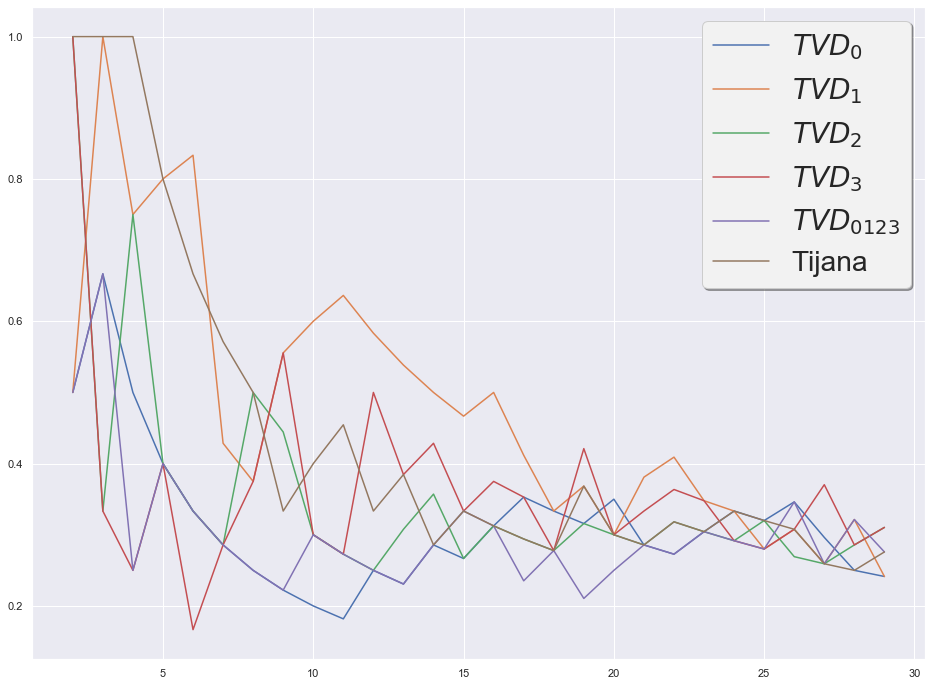

In [55]:
fig, ax = plt.subplots(figsize=(16,12))

plt.plot(range(2,MAX_CLUSTER), tvd0_spectral_middle_coverage, label=r'$TVD_0$');
#plt.fill_between(range(2,MAX_CLUSTER), tvd0_spectral_high_coverage, tvd0_spectral_low_coverage, alpha=0.1);

plt.plot(range(2,MAX_CLUSTER), tvd1_spectral_middle_coverage, label=r'$TVD_1$');
#plt.fill_between(range(2,MAX_CLUSTER), tvd1_spectral_high_coverage, tvd1_spectral_low_coverage, alpha=0.1);

plt.plot(range(2,MAX_CLUSTER), tvd2_spectral_middle_coverage, label=r'$TVD_2$');
#plt.fill_between(range(2,MAX_CLUSTER), tvd2_spectral_high_coverage, tvd2_spectral_low_coverage, alpha=0.1);

plt.plot(range(2,MAX_CLUSTER), tvd3_spectral_middle_coverage, label=r'$TVD_3$');
#plt.fill_between(range(2,MAX_CLUSTER), tvd3_spectral_high_coverage, tvd3_spectral_low_coverage, alpha=0.1);

plt.plot(range(2,MAX_CLUSTER), tvd0123_spectral_middle_coverage, label=r'$TVD_{0123}$');
#plt.fill_between(range(2,MAX_CLUSTER), tvd0123_spectral_high_coverage, tvd0123_spectral_low_coverage, alpha=0.1);

plt.plot(range(2,MAX_CLUSTER), tijana_spectral_middle_coverage, label=r'Tijana');
#plt.fill_between(range(2,MAX_CLUSTER), tijana_spectral_high_coverage, tijana_spectral_low_coverage, alpha=0.1);

ax.legend(fontsize=28, shadow=True, facecolor=[0.95, 0.95, 0.95, 0]);

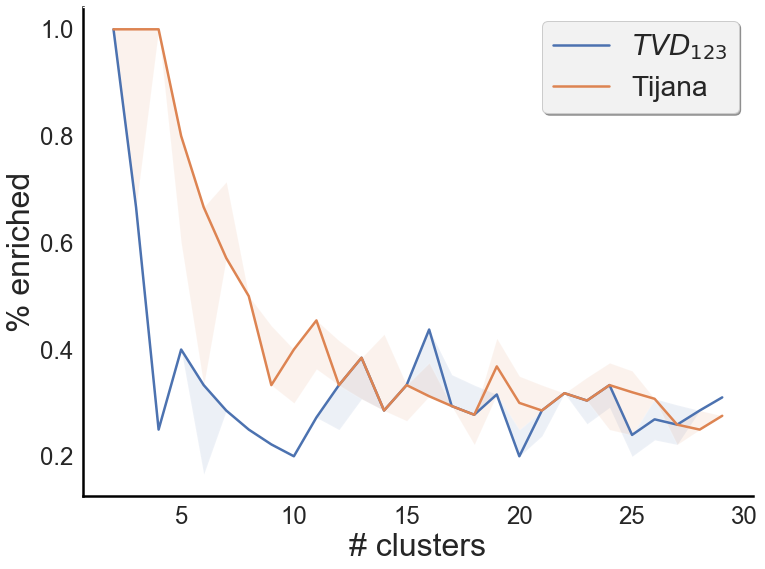

In [97]:
tvd='123'

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

plt.plot(range(2,MAX_CLUSTER), eval(f"tvd{tvd}_spectral_middle_coverage"), 
         label=r'$TVD_{123}$', 
         linewidth=2.5);
plt.fill_between(range(2,MAX_CLUSTER), 
                 eval(f"tvd{tvd}_spectral_high_coverage"), 
                 eval(f"tvd{tvd}_spectral_low_coverage"), 
                 alpha=0.1);


plt.plot(range(2,MAX_CLUSTER), tijana_spectral_middle_coverage, 
         label=r'Tijana',
         linewidth=2.5);
plt.fill_between(range(2,MAX_CLUSTER), tijana_spectral_high_coverage, tijana_spectral_low_coverage, alpha=0.1);


ax.set_xlabel('# clusters', fontsize=32)
ax.set_ylabel('% enriched', fontsize=32)
ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color('black')

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color('black')

ax.legend(fontsize=28, shadow=True, facecolor=[0.95, 0.95, 0.95, 0]);
fig.savefig(f"data/plots/tvd_{tvd}.png")

### Testing tijana.cpp

In [40]:
def tijana_distance(GDV):
    LogGDV = np.log(np.array(GDV+1))

    orbit_dependencies = np.array((1,2,2,2,3,4,3,3,4,3,4,4,4,4,3))
    weights = 1 - np.log(orbit_dependencies) / np.log(len(orbit_dependencies))
    
    sqD = [np.sum(weights*np.abs(LogGDV[i,:]-LogGDV[j,:]) / np.log(np.max([GDV[i,:],GDV[j,:]], axis=0)+2))
              for (i,j) in combinations(range(len(GDV)), 2)]

    return squareform(sqD) / np.sum(weights)

In [ ]:
n = 500
G = nx.erdos_renyi_graph(n,0.5)
GDV = graco.orbits(G, dtype=np.ndarray)

In [44]:
np.savetxt(f"/Users/markusyoussef/Desktop/git/graco/graco/cpp/matrix.in", test, 
           header=f"{len(test)} 15", fmt='%d')

In [49]:
D1 = tijana_distance(test)
D2 = np.genfromtxt(f"/Users/markusyoussef/Desktop/git/graco/graco/cpp/matrix.out")

In [14]:
G = nx.erdos_renyi_graph(100, 0.01)
GDV = graco.orbits(G)

In [16]:
np.savetxt("/home/clusterduck123/Desktop/sam/GDV.in", GDV,
            header=f"{len(GDV)} 15", fmt="%d")

In [ ]:
from scipy.spatial.distance import squareform